In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *
from autoencoder.supervise import equation
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

## Plotting functions

In [3]:
# plot true u and reconstructed u
def plot_u(u, u_hat):
    """
    Samples 3 solutions u and their corresponding
    reconstructed solutions u_hat from the semantic 
    autoencoder, and plots both u and u_hat
    """
    domain = np.linspace(0., 1., 100)
    num_plots = 3
    num_u = u.shape[0]
    sample_idxs = np.random.randint(0, num_u - 1, num_plots)
    
    fig, ax = plt.subplots(1, num_plots, figsize=(20,8), dpi=200)
    for i, s in enumerate(sample_idxs):
        ax[i].plot(domain, u[s], linewidth=3)
        ax[i].plot(domain, u_hat[s], linewidth=3)
    fig.legend([r'$u$', r'$\hat u$'])
    plt.show(fig)
    plt.close(fig)

In [4]:
# plot true theta and learned theta
def plot_theta(theta, theta_hat):
    t_names = [r'$u_0$', r'$u_1$', r'$c$']
    num_indices = theta.shape[0]
    indices = [idx + 1 for idx in range(num_indices)]
    indices = np.array(indices)
    num_plots = theta.shape[1]
    
    fig, ax = plt.subplots(1, num_plots, figsize=(20,8), dpi=200)
    for i in range(num_plots):
        sort_idx = np.argsort(theta[:, i])
        ax[i].scatter(indices, theta[sort_idx, i])
        ax[i].scatter(indices, theta_hat[sort_idx, i], alpha=0.4)
        ax[i].set_title(t_names[i])
    fig.legend([r'$\theta$', r'$\hat\theta$'])
    plt.show(fig)
    plt.close(fig)

## Load data

In [5]:
# load data
dataset = equation.Dataset('poisson')
dataset.load()
x_train, y_train = dataset.train
x_test, y_test = dataset.test
x_val, y_val = dataset.validate

## Build network

In [6]:
# network parameters
tf.config.experimental_run_functions_eagerly(True)
latent_dim = 3
batch_size = 25
input_shape = (100,)
input_u = Input(shape=input_shape)

In [7]:
# encoder
x = Dense(50, 'relu', name='hidden_1')(input_u)
x = Dense(20, 'relu', name='hidden_2')(x)
theta = Dense(latent_dim, 'linear', name='theta')(x)

In [8]:
# analytic decoder
def analytic_decoder(theta):
    u0, u1, c = tf.split(theta, 3, axis=1)
    x = np.linspace(0., 1., 100)
    x2 = x ** 2
    ux2 = tf.math.divide(c, -2.)
    ux2 = tf.math.multiply(ux2, x2)
    ux = tf.math.divide(c, 2.)
    ux = tf.math.add(ux, u1)
    ux = tf.math.subtract(ux, u0)
    ux = tf.math.multiply(ux, x)
    u = tf.math.add(ux2, ux)
    u = tf.math.add(u, u0)
    return u

reconstructed_u = Lambda(analytic_decoder, name='u_hat')(theta)

In [9]:
# compile model
sae = tf.keras.Model(input_u, reconstructed_u)
sae.compile('adam', 'mse')
sae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
hidden_1 (Dense)             (None, 50)                5050      
_________________________________________________________________
hidden_2 (Dense)             (None, 20)                1020      
_________________________________________________________________
theta (Dense)                (None, 3)                 63        
_________________________________________________________________
u_hat (Lambda)               (None, 100)               0         
Total params: 6,133
Trainable params: 6,133
Non-trainable params: 0
_________________________________________________________________


## Train and evaluate

In [10]:
# fit model
sae.fit(x=x_train, y=x_train, epochs=100, batch_size=batch_size, verbose=0)

In [11]:
print(sae.evaluate(x_test, x_test, verbose=0))
print(sae.evaluate(x_val, x_val, verbose=0))

0.012047972530126572
0.013501334004104137


## Plots

In [12]:
# extract theta estimates
get_theta = tf.keras.Model(sae.input, sae.get_layer('theta').output)
theta_hat = get_theta(x_val).numpy()

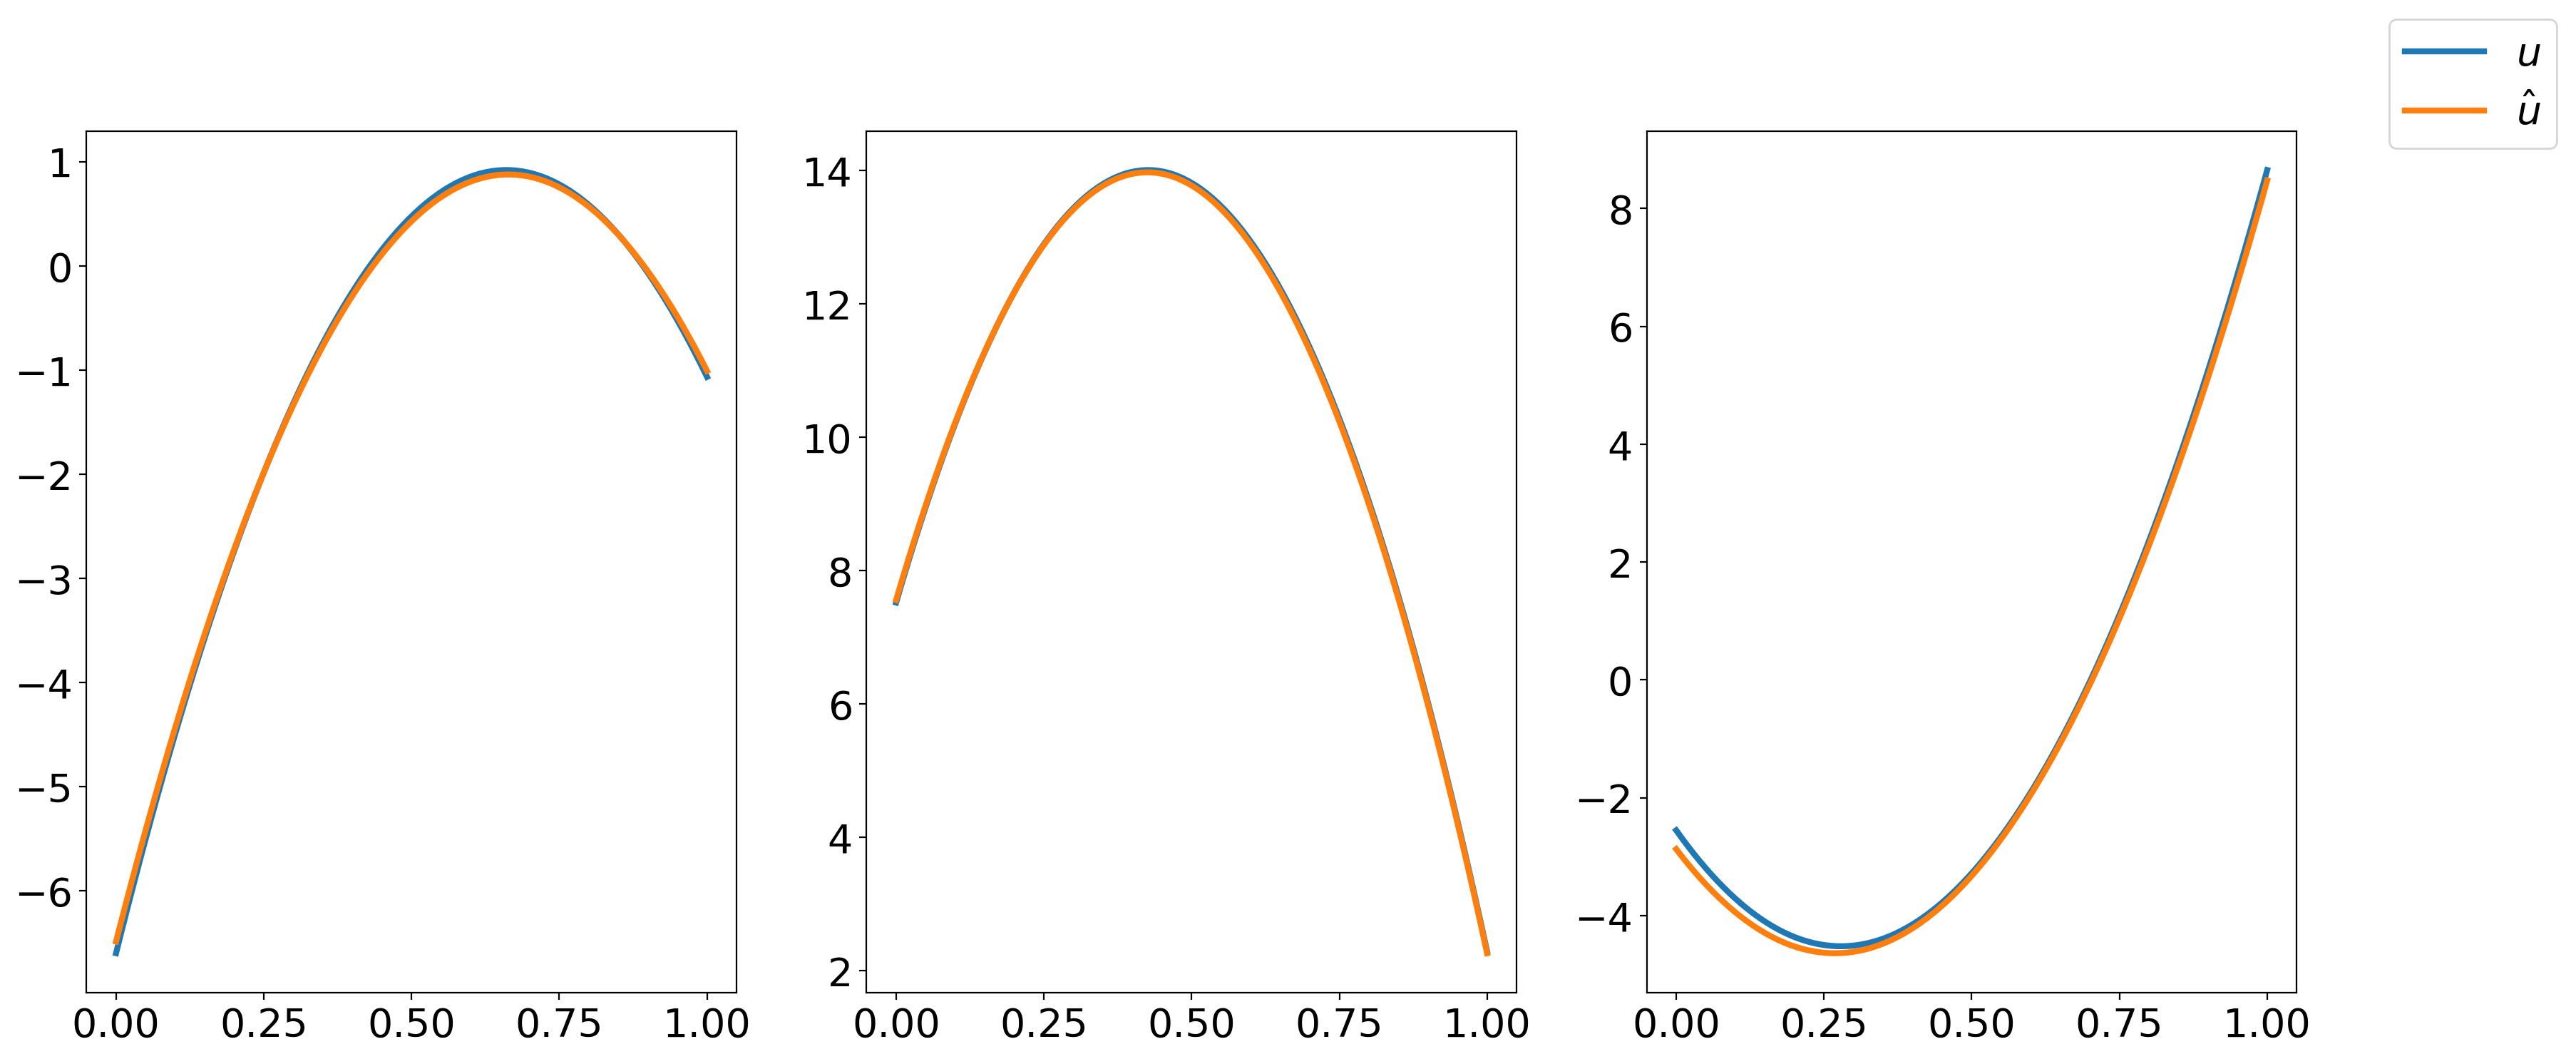

In [13]:
# validation set plots
x_val_hat = sae.predict(x_val)
plot_u(x_val, x_val_hat)

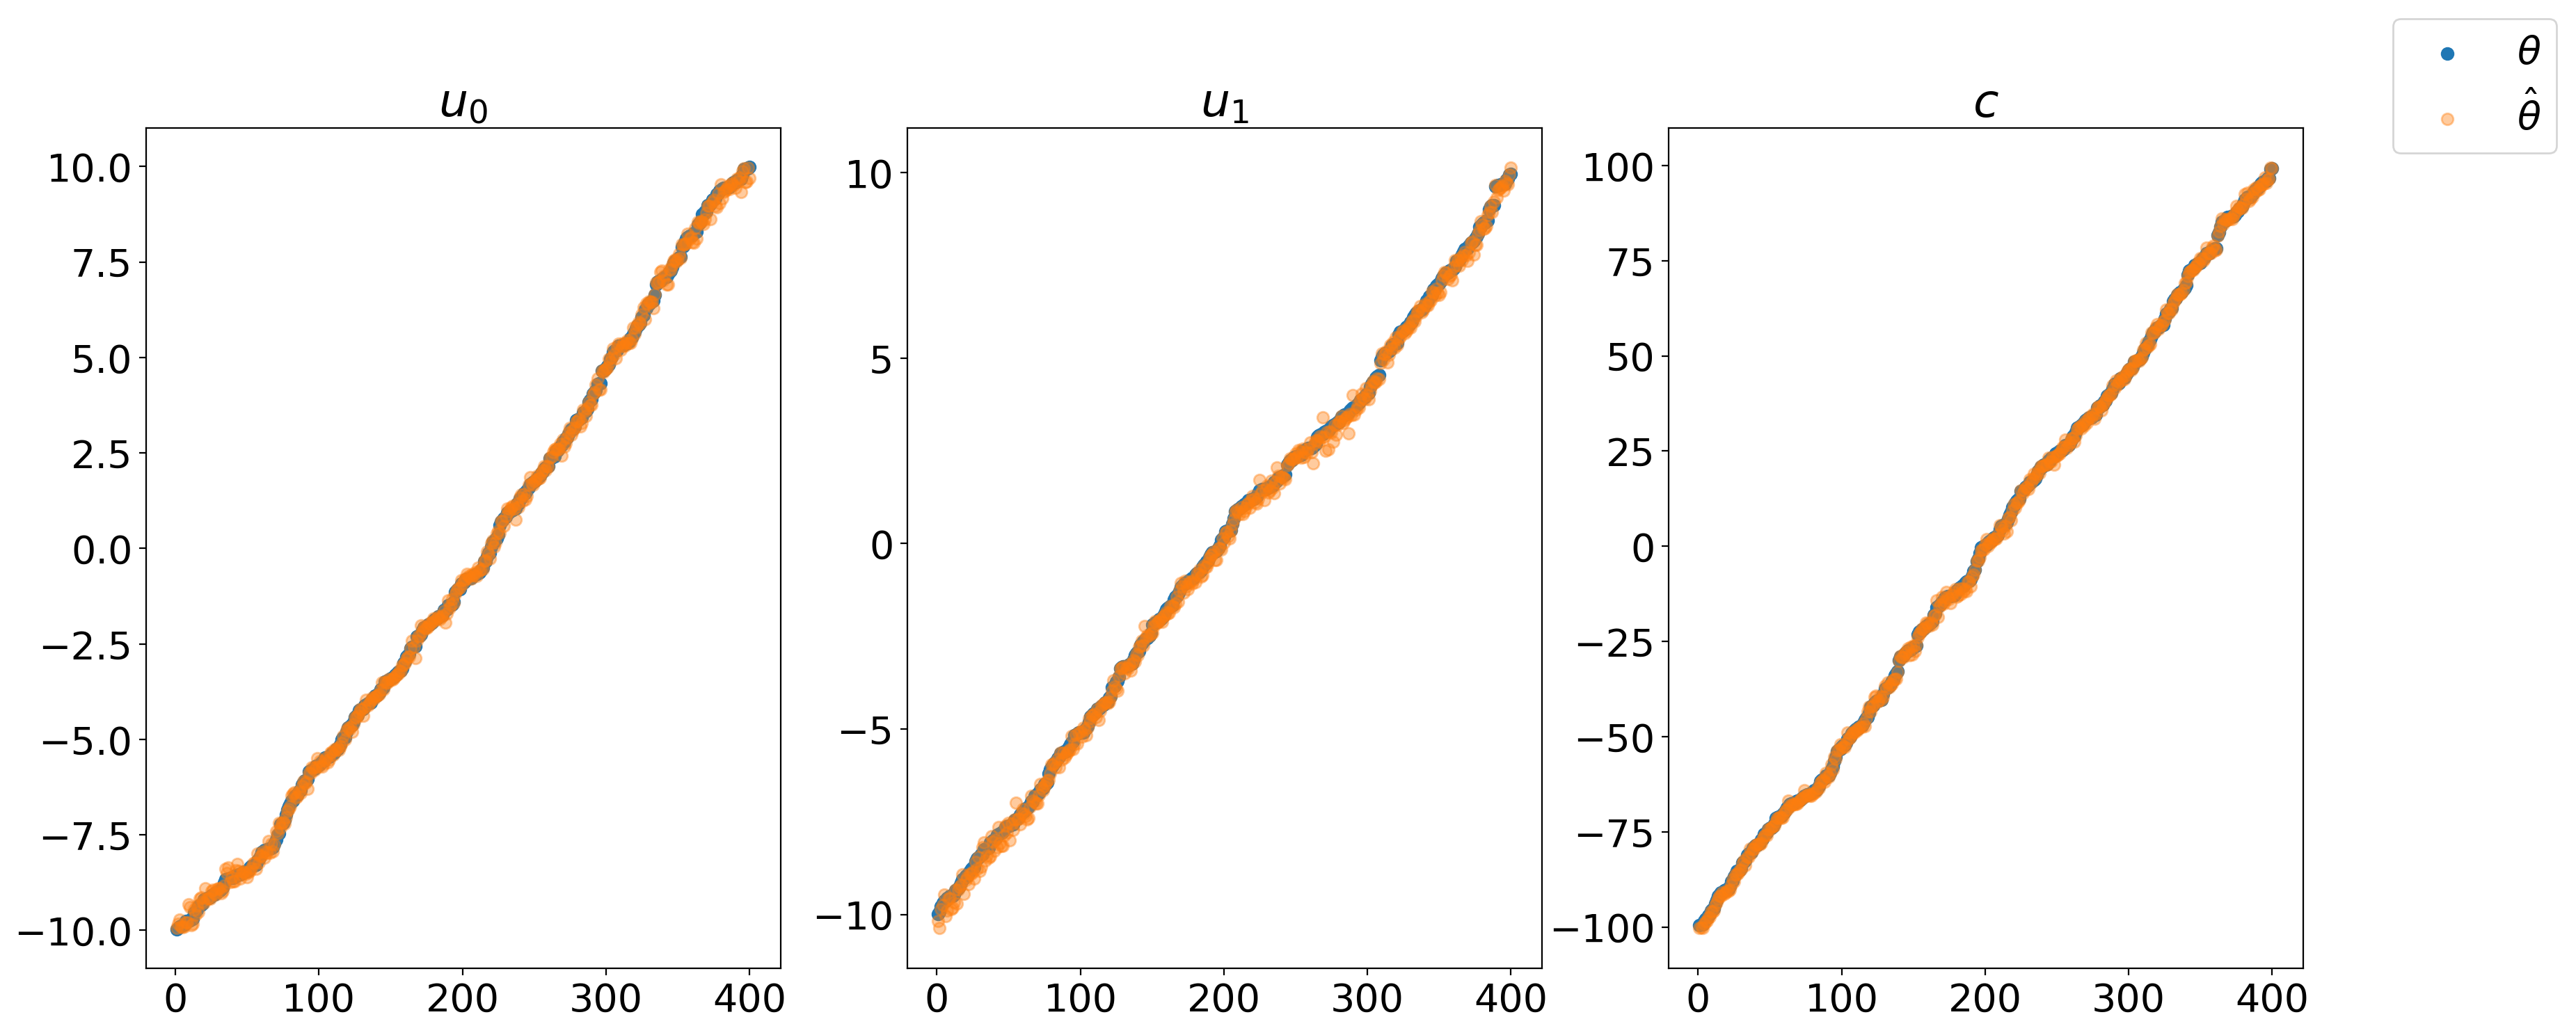

In [14]:
plot_theta(y_val, theta_hat)

## Testing robustness

In [17]:
epsilon = np.random.randn(x_test.size).reshape(400, 100)
x_test_noisy = x_test + 2. * epsilon
x_test_noisy_hat = sae.predict(x_test_noisy)
theta_test_noisy_hat = get_theta(x_test_noisy).numpy()

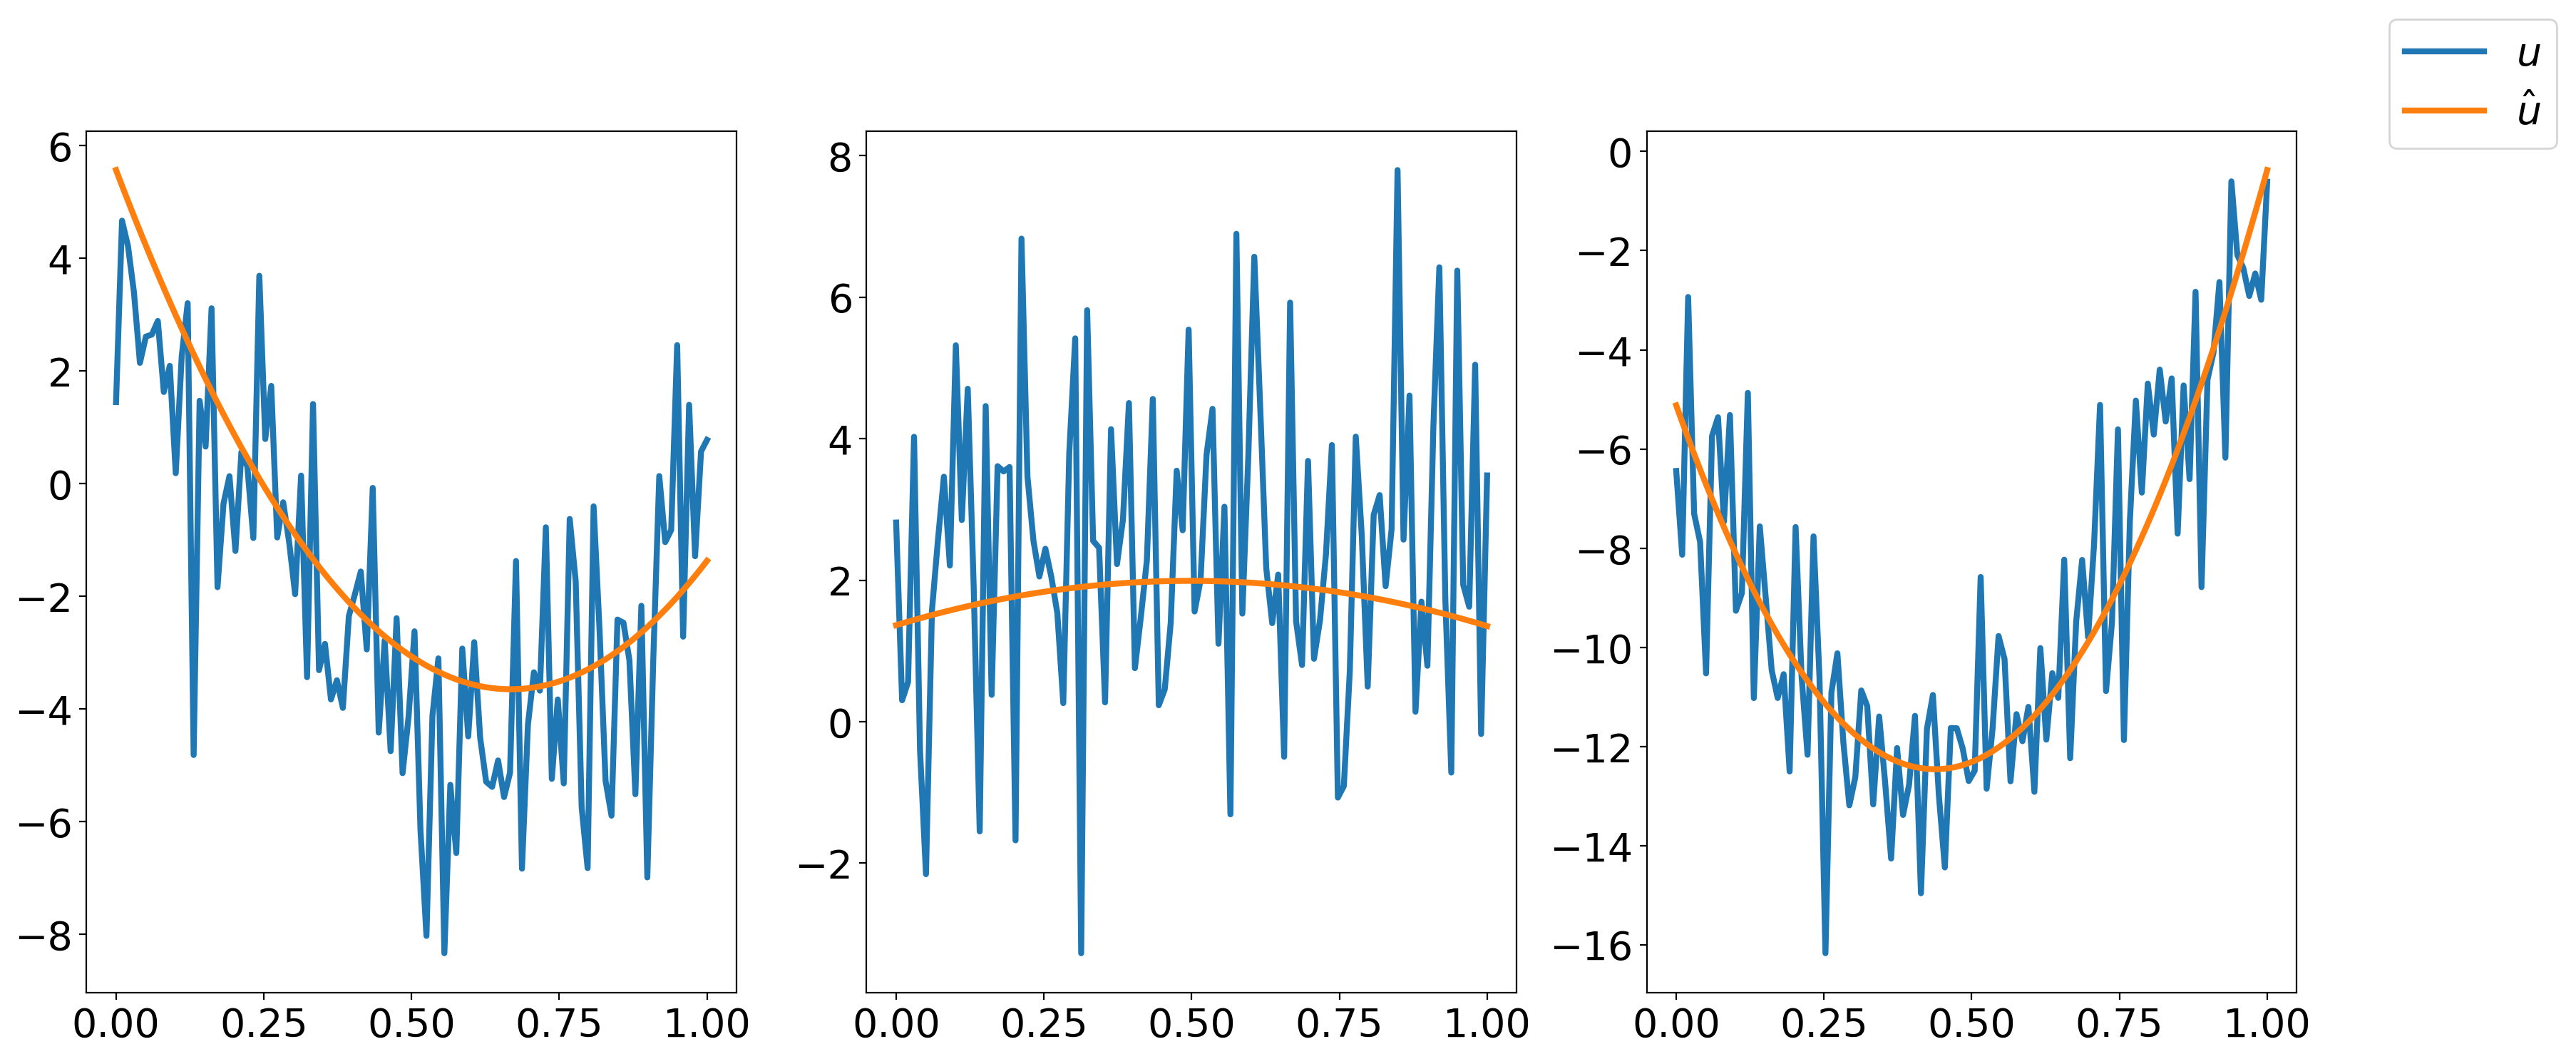

In [18]:
plot_u(x_test_noisy, x_test_noisy_hat)

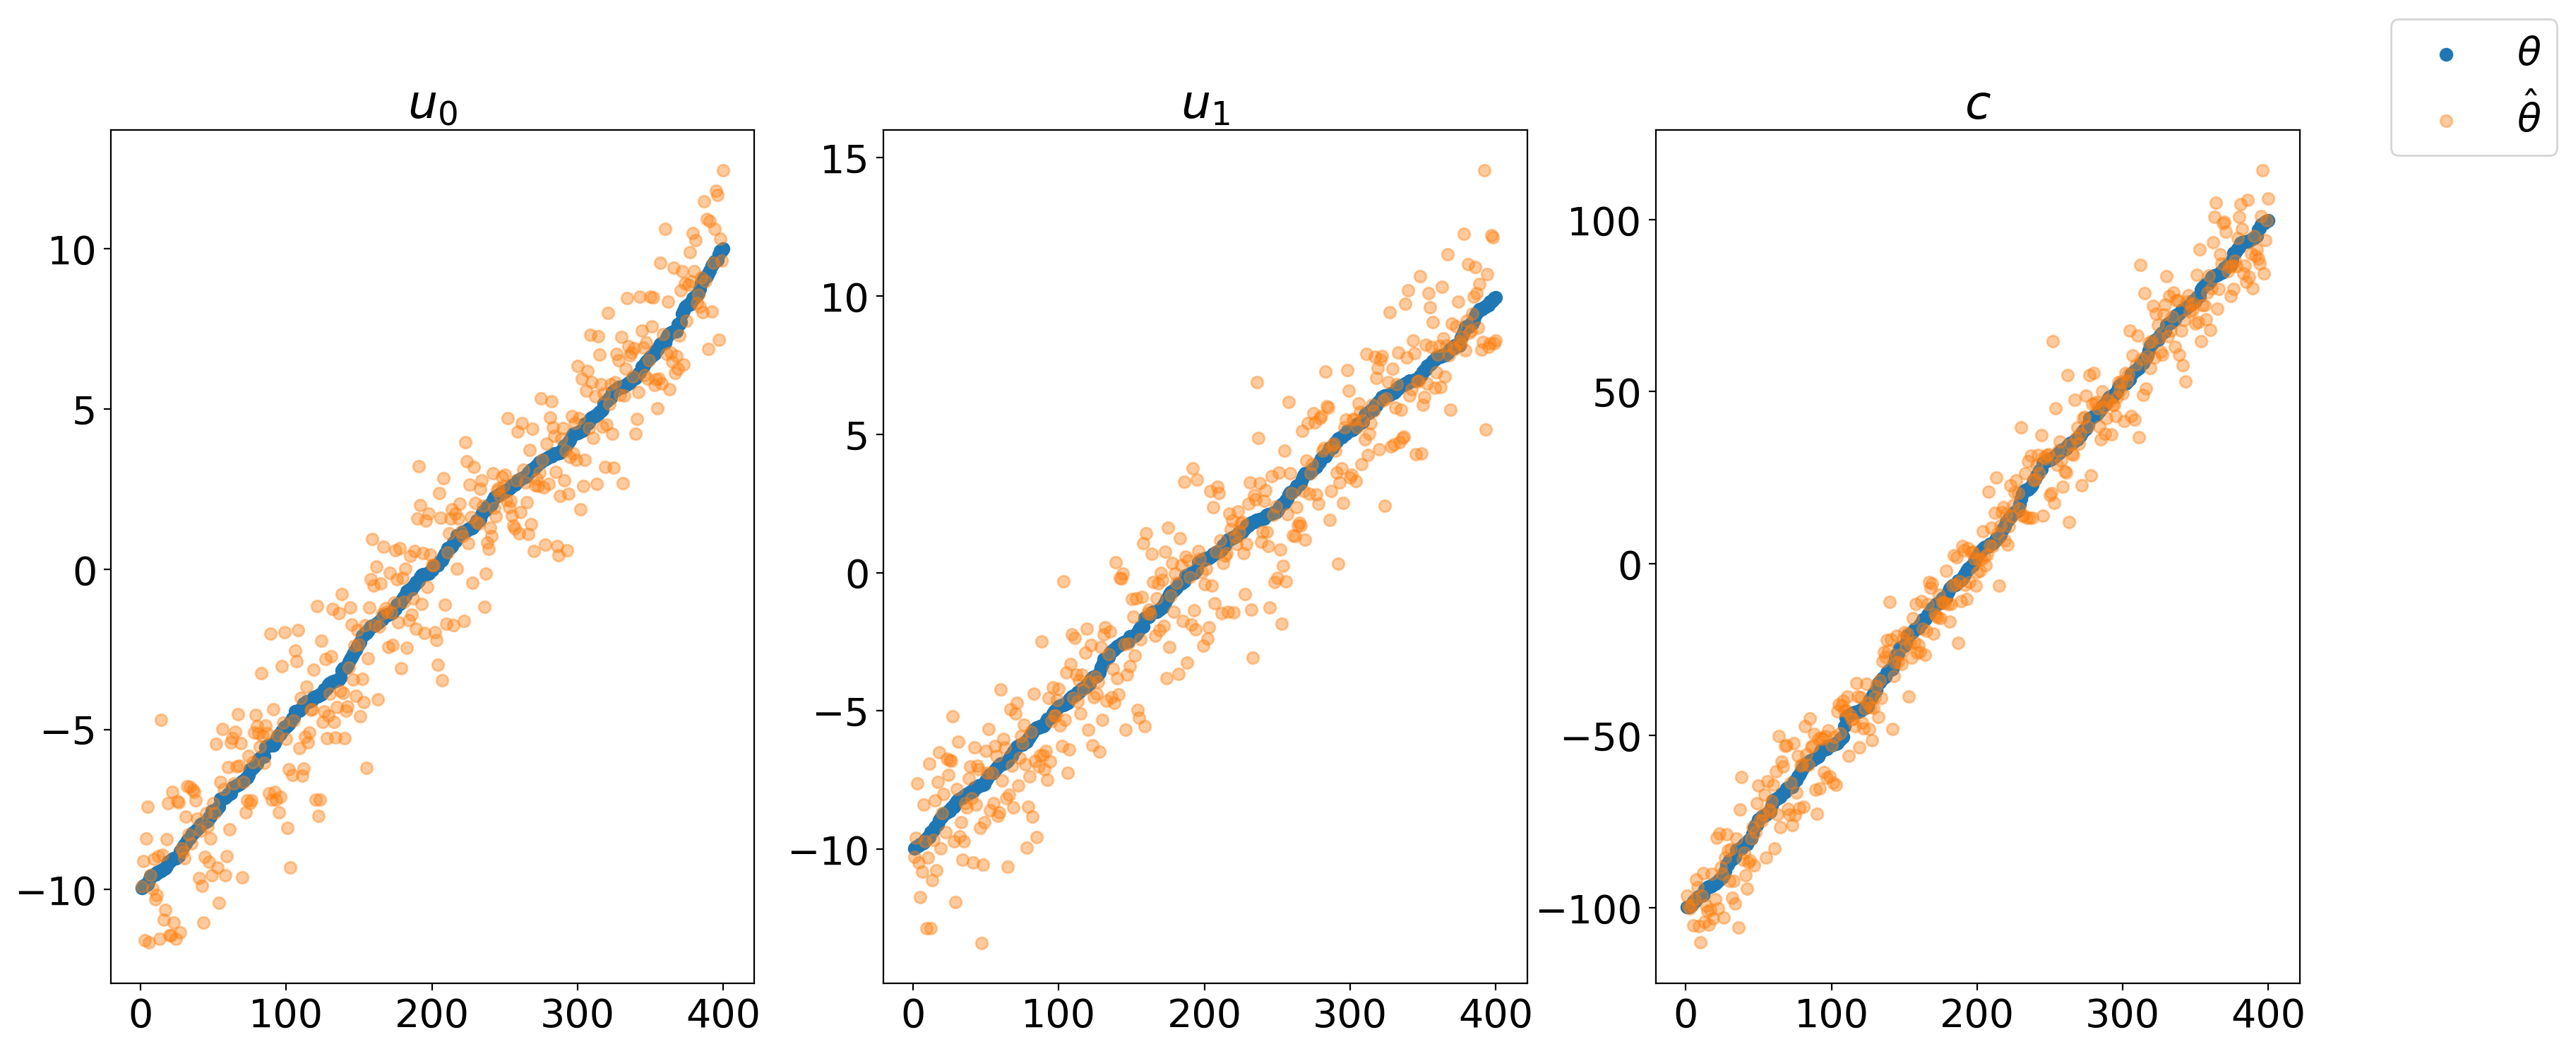

In [19]:
plot_theta(y_test, theta_test_noisy_hat)